The estimation of Feature Importance based on a Linear Regression model.

Analyzing the most important features in the input dataframe with respect to a simple linear regression model. 
For this reason, first all the highly correlated features were dropped according to result of VIF and 
then regression model was applied to estimate the importance of each remaining features.


In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from utils import get_clean_dataset

In [3]:
df = get_clean_dataset()

array([[<AxesSubplot: title={'center': 'DAM_perc_dmg'}>]], dtype=object)

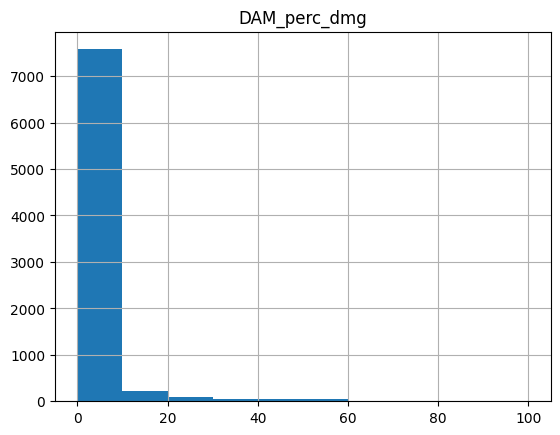

In [4]:
# Show histogram of damage
df.hist(column="DAM_perc_dmg")

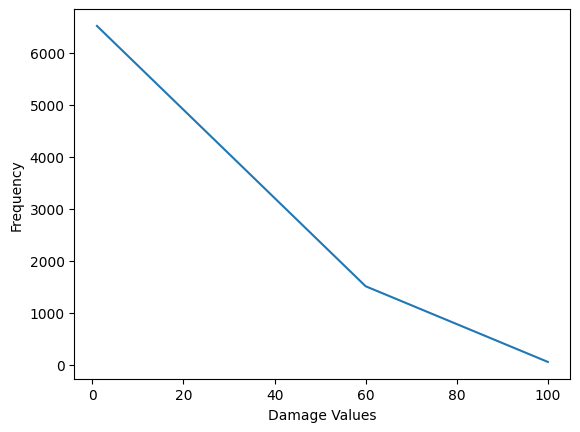

In [5]:
# A bin's set defined to categorize target values in different groups(bins)
# The chosen bins
bins2 = [0, 1, 60, 100]
samples_per_bin2, binsP2 = np.histogram(df["DAM_perc_dmg"], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
# Display bins
print(samples_per_bin2)
print(binsP2)

[6517 1506   50]
[  0   1  60 100]


In [7]:
bin_index2 = np.digitize(df["DAM_perc_dmg"], bins=binsP2)

In [8]:
y_input_strat = bin_index2

In [9]:
# TODO: what is this list?
features = [
    "HAZ_rainfall_Total",
    "HAZ_v_max",
    "GEN_landslide_per",
    "GEN_stormsurge_per",
    "GEN_Red_per_LSbldg",
    "GEN_Or_per_LSblg",
    "GEN_OR_per_SSAbldg",
    "GEN_Yellow_per_LSbl",
    "TOP_mean_slope",
    "GEN_with_coast",
    "GEN_coast_length",
    "VUL_Housing_Units",
    "VUL_StrongRoof_StrongWall",
    "VUL_StrongRoof_SalvageWall",
    "VUL_LightRoof_StrongWall",
    "VUL_LightRoof_LightWall",
    "VUL_LightRoof_SalvageWall",
    "VUL_SalvagedRoof_StrongWall",
    "VUL_SalvagedRoof_LightWall",
    "VUL_SalvagedRoof_SalvageWall",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


# Split dataset into training set and test set and applying data stratification according to the defined bins
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["DAM_perc_dmg"], stratify=y_input_strat, test_size=0.2
)

Index(['HAZ_rainfall_Total', 'HAZ_v_max', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl', 'TOP_mean_slope',
       'GEN_with_coast', 'GEN_coast_length', 'VUL_Housing_Units',
       'VUL_StrongRoof_StrongWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall'],
      dtype='object')

In [10]:
regressor = LinearRegression()
model_regr = regressor.fit(X_train, y_train)

In [11]:
feature = []
values = []
importance = regressor.coef_
# print(importance)
for i, j in enumerate(importance):
    print("Feature %0d " % (i) + X.columns[i] + ":, Score: %.5f" % (j))

    feature.append(X.columns[i])
    values.append(j)

Feature 0 HAZ_rainfall_Total:, Score: -0.53819
Feature 1 HAZ_v_max:, Score: 4.57464
Feature 2 GEN_landslide_per:, Score: -0.37135
Feature 3 GEN_stormsurge_per:, Score: 0.41684
Feature 4 GEN_Red_per_LSbldg:, Score: 0.32659
Feature 5 GEN_Or_per_LSblg:, Score: -0.06023
Feature 6 GEN_OR_per_SSAbldg:, Score: -0.20620
Feature 7 GEN_Yellow_per_LSbl:, Score: -0.05200
Feature 8 TOP_mean_slope:, Score: -0.49831
Feature 9 GEN_with_coast:, Score: 0.21636
Feature 10 GEN_coast_length:, Score: -0.19966
Feature 11 VUL_Housing_Units:, Score: -0.12288
Feature 12 VUL_StrongRoof_StrongWall:, Score: -0.88482
Feature 13 VUL_StrongRoof_SalvageWall:, Score: 0.85716
Feature 14 VUL_LightRoof_StrongWall:, Score: 0.30742
Feature 15 VUL_LightRoof_LightWall:, Score: -0.22099
Feature 16 VUL_LightRoof_SalvageWall:, Score: 0.20907
Feature 17 VUL_SalvagedRoof_StrongWall:, Score: -0.12912
Feature 18 VUL_SalvagedRoof_LightWall:, Score: 0.15633
Feature 19 VUL_SalvagedRoof_SalvageWall:, Score: 0.03384


In [12]:
# Creating a dataframe of features and their coefficient values

df_coef = pd.DataFrame(columns=["feature", "coef_value"])
df_coef["feature"] = feature
df_coef["coef_value"] = values

df_coef

,feature,coef_value
0,HAZ_rainfall_Total,-0.538190
1,HAZ_v_max,4.574642
2,GEN_landslide_per,-0.371345
3,GEN_stormsurge_per,0.416845
4,GEN_Red_per_LSbldg,0.326593
5,GEN_Or_per_LSblg,-0.060233
6,GEN_OR_per_SSAbldg,-0.206202
7,GEN_Yellow_per_LSbl,-0.052003
8,TOP_mean_slope,-0.498310
9,GEN_with_coast,0.216359


In [13]:
# Sorting the dataframe of coefficient values in a descending order

final_sorted_df = df_coef.sort_values(by=["coef_value"], ascending=False)
final_sorted_df = final_sorted_df.reset_index(drop=True)
final_sorted_df

,feature,coef_value
0,HAZ_v_max,4.574642
1,VUL_StrongRoof_SalvageWall,0.857164
2,GEN_stormsurge_per,0.416845
3,GEN_Red_per_LSbldg,0.326593
4,VUL_LightRoof_StrongWall,0.307418
5,GEN_with_coast,0.216359
6,VUL_LightRoof_SalvageWall,0.209070
7,VUL_SalvagedRoof_LightWall,0.156334
8,VUL_SalvagedRoof_SalvageWall,0.033836
9,GEN_Yellow_per_LSbl,-0.052003


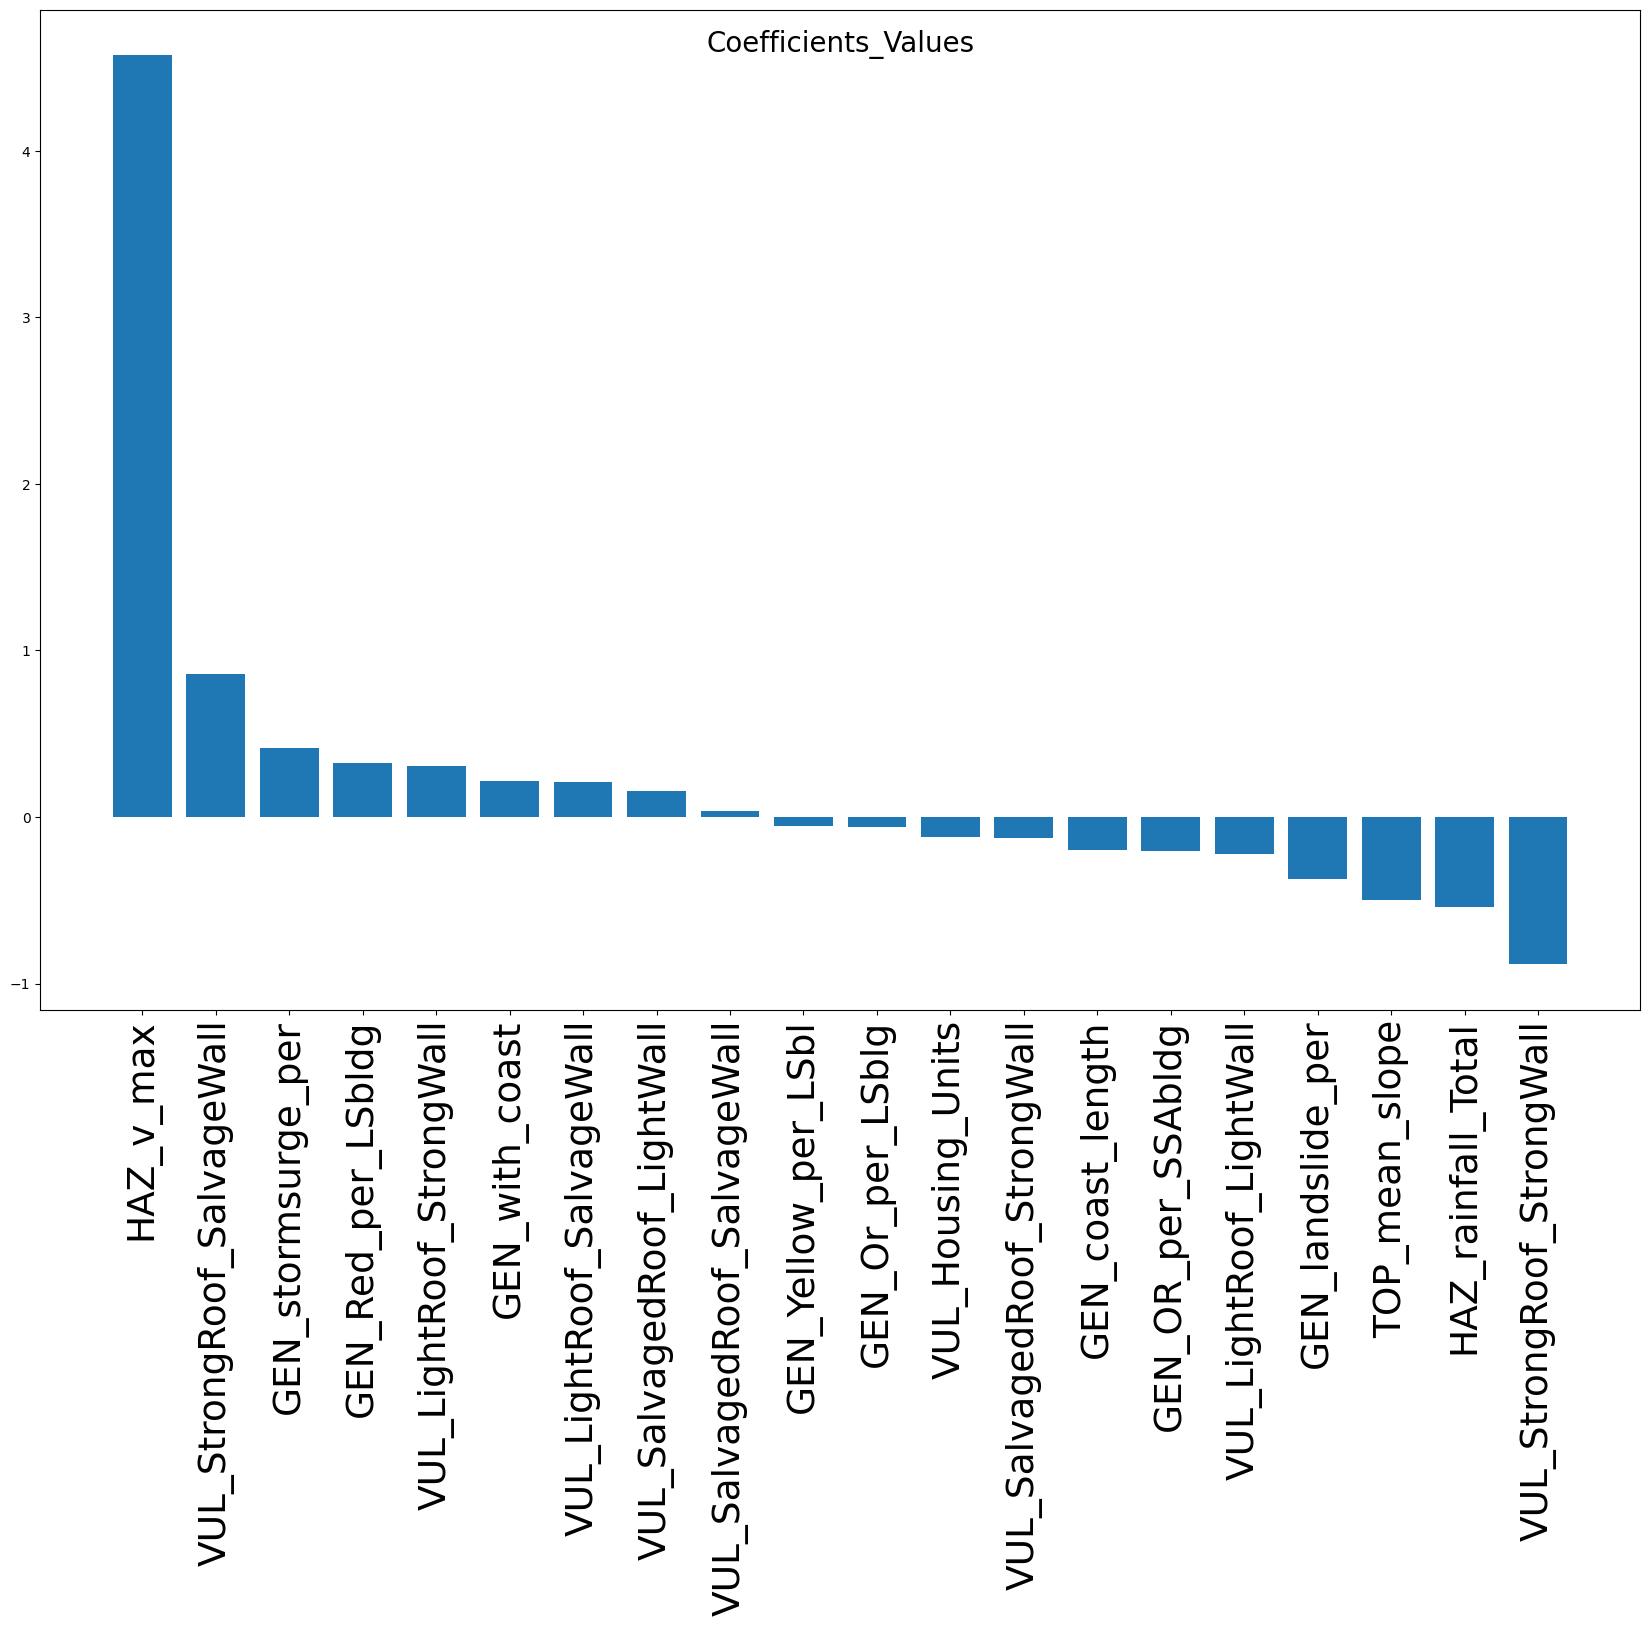

In [14]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle("Coefficients_Values", fontsize=20)
ax = fig.add_axes([0, 0, 1, 1])
# ax.bar(features,values)
ax.bar(final_sorted_df["feature"], final_sorted_df["coef_value"])
np.rot90(plt.xticks(rotation=90, fontsize=27))
plt.show()

In [15]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     120.8
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:57:50   Log-Likelihood:                -22493.
No. Observations:                6458   AIC:                         4.503e+04
Df Residuals:                    6437   BIC:                         4.517e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4444      0.098     24.887      0.0

In [16]:
fea = X.columns
fea.tolist()
fea_1 = pd.DataFrame(columns=["names"])
fea_1["names"] = fea.tolist()
fea_1

,names
0,HAZ_rainfall_Total
1,HAZ_v_max
2,GEN_landslide_per
3,GEN_stormsurge_per
4,GEN_Red_per_LSbldg
5,GEN_Or_per_LSblg
6,GEN_OR_per_SSAbldg
7,GEN_Yellow_per_LSbl
8,TOP_mean_slope
9,GEN_with_coast
